In [1]:
%cd ~/group/lab/jianyu/projects/TCAV/1_code/0_Kipoi_models/

/data/lab/jianyu/projects/TCAV/1_code/0_Kipoi_models


In [2]:
import logomaker
import torch
import re, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import textwrap

from Bio import motifs
from functools import partial
from glob import glob
from pyjaspar import jaspardb
from sklearn.metrics import precision_recall_fscore_support as score
from tqdm import tqdm
from matplotlib import gridspec
from pybedtools import BedTool
from gprofiler import GProfiler

In [3]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
import matplotlib
matplotlib.rc('pdf', fonttype=42)
from fastcluster import linkage
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, leaves_list
from scipy.stats import zscore
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
#from cuml.cluster import AgglomerativeClustering 

In [18]:
# Parameters
cav_root_dir = "output/pipeline_test_5000_36_motifs/cavs/"
cav_dir_patterns = ["AC0134:HSF:HSF*","AC0077:ZIC-GLIS:C2H2_ZF*","AC0108:KLF-SP:C2H2_ZF*","AC0290:FOXP:Forkhead*","AC0587:POU5F-NANOG:Homeodomain,POU*",
                    "AC0109:SP-KLF:C2H2_ZF*","AC0588:POU2F-POU3F:Homeodomain,POU*","AC0581:ZSCAN:C2H2_ZF*","AC0004:ZSCAN:C2H2_ZF*",
                    "AC0008:VENTX:Homeodomain*","AC0262:SOX-SRY:Sox*","AC0424:NR4A:Nuclear_receptor*","AC0373:ZBTB:C2H2_ZF*","AC0115:ZNF:C2H2_ZF*",
                    "AC0114:ZNF-VEZF:C2H2_ZF*","AC0456:ZNF-PRDM:C2H2_ZF*","AC0259:SOX:Sox*","AC0110:ZNF-MAZ:C2H2_ZF*","AC0442:ZNF:C2H2_ZF*",
                    "AC0395:SOX:Sox*","AC0104:ZNF:C2H2_ZF*","AC0309:ZNF:C2H2_ZF*","AC0614:LHX:Homeodomain*","AC0525:NFYA-NFYB:CBF-NF-Y*",
                    "AC0529:ZNF:C2H2_ZF*","AC0120:RREB:C2H2_ZF*","AC0267:SOX-SRY:Sox*","AC0051:PLAG:C2H2_ZF*","AC0098:ZNF:C2H2_ZF*","AC0126:ZNF:C2H2_ZF*",
                    "DNA*",
                    "LINE*",
                    "Low*",
                    "LTR*",
                    "Other*",
                    "Satellite*",
                    "scRNA*",
                    "Simple*",
                    "SINE*"]

layer_attrs_prefixes = {"Nanog": "output/pipeline_test_5000_36_motifs/Nanog_peaks_task_Nanog_counts",
                        "Klf4": "output/pipeline_test_5000_36_motifs/Klf4_peaks_task_Klf4_counts",
                        "Sox2": "output/pipeline_test_5000_36_motifs/Sox2_peaks_task_Sox2_counts",
                        "Oct4": "output/pipeline_test_5000_36_motifs/Oct4_peaks_task_Oct4_counts",}

output_dir = "output/tcavs/TEST/"
fscore_threshold = 0.90

motifs_pwm_meme = "TPCAV/data/motif-clustering-v2.1beta_consensus_pwms.meme"

In [19]:
cav_dirs = {}
for p in cav_dir_patterns:
    for cd in glob(f"{cav_root_dir}/{p}"):
        cn = os.path.basename(cd)
        cav_dirs[cn] = cd

In [20]:
os.makedirs(output_dir, exist_ok=True)

In [21]:
layer_attrs = {
    k: torch.load(f'{prefix}.attributions.pt') for k, prefix in layer_attrs_prefixes.items()
}

/tmp/ipykernel_2300022/3491937093.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  k: torch.load(f'{prefix}.attributions.pt') for k, prefix in layer_attrs_prefixes.items(

In [22]:
tcav_expts = []
for cn, cav_dir in cav_dirs.items():
    concept, control = cn.split("_control_")
    tcav_expts.append((concept, control, cav_dir))
tcav_expts = pd.DataFrame(tcav_expts, columns=['concept', 'control', 'cav_dir'])

In [23]:
tcav_expts

,concept,control,cav_dir
0,AC0134:HSF:HSF,random_regions,output/pipeline_test_5000_36_motifs/cavs/AC013...
1,AC0077:ZIC-GLIS:C2H2_ZF,random_regions,output/pipeline_test_5000_36_motifs/cavs/AC007...
2,AC0108:KLF-SP:C2H2_ZF,random_regions,output/pipeline_test_5000_36_motifs/cavs/AC010...
3,AC0290:FOXP:Forkhead,random_regions,output/pipeline_test_5000_36_motifs/cavs/AC029...
4,"AC0587:POU5F-NANOG:Homeodomain,POU",random_regions,output/pipeline_test_5000_36_motifs/cavs/AC058...
...,...,...,...
208,SINE_PB1D10,random_regions,output/pipeline_test_5000_36_motifs/cavs/SINE_...
209,SINE_PB1D11,random_regions,output/pipeline_test_5000_36_motifs/cavs/SINE_...
210,SINE_PB1D7,random_regions,output/pipeline_test_5000_36_motifs/cavs/SINE_...
211,SINE_PB1D9,random_regions,output/pipeline_test_5000_36_motifs/cavs/SINE_...


In [4]:
rng = np.random.default_rng(1)

In [5]:
def compute_tcav(cav, attr):

    tcav = torch.matmul(torch.flatten(attr, start_dim=1), cav.T)
    print(cav.shape, attr.shape)
    tcav_score = ((tcav>0)*1.).mean(axis=0).cpu().numpy()

    return tcav, tcav_score

In [36]:
def log_ratio(x):
    return np.log((x['tcav_pos_ratio_test']+0.01)/(x['tcav_pos_ratio_control']+0.01))

dfs = []
cavs = defaultdict(list)
tcavs = defaultdict(list)

fscores = []
for item in tqdm(tcav_expts.itertuples()):

    prefix_dir = item.cav_dir
    
    perform = pd.read_table(f"{prefix_dir}/classifier_perform_on_test.txt", 
                            comment="#")

    precision, recall, fscore, support = score(perform.Truth, perform.Pred)

    fscores.append(np.mean(fscore))

    # here predictions are model outputs, so it's usually expected that concepts 0 has a higher probability of being bound
    #model_predictions_0 = np.loadtxt(f"{prefix_dir}/predictions_concept_0.txt")
    #model_predictions_1 = np.loadtxt(f"{prefix_dir}/predictions_concept_1.txt")
    
    classifier_scores = pd.DataFrame({'precision': precision,
                  'recall': recall,
                  'fscore': fscore,
                  'support': support})

    cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()
    cavs[item.concept].append(cav)

    for key, attr in layer_attrs.items():
        
        tcav, tcav_score = compute_tcav(cav, attr)
        tcavs[item.concept].append(tcav)

        tcav_log_ratio = np.log((tcav_score[0]+0.01)/(tcav_score[1]+0.01))
    
        dfs.append((np.mean(fscore), support, tcav_log_ratio, item.concept, item.control, key))

dfs_merge = pd.DataFrame(dfs, columns=['fscore', 'support', 'tcav_log_ratio', 
                                       'concept', 'control', 'layer_attr_key'])

#dfs_merge['concept_name'] = dfs_merge.apply(lambda x: f'Random genome with\n{x["concept"]} inserted' if x['concept_id']==0 else 'Random genome', axis=1)

0it [00:00, ?it/s]/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


1it [00:02,  2.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


2it [00:04,  2.05s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


3it [00:05,  1.84s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


4it [00:07,  1.76s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


5it [00:09,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


6it [00:10,  1.62s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


7it [00:12,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


8it [00:14,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


9it [00:15,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


10it [00:17,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


11it [00:19,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


12it [00:20,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


13it [00:22,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


14it [00:24,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


15it [00:26,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


16it [00:27,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


17it [00:29,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


18it [00:31,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


19it [00:33,  1.77s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


20it [00:34,  1.78s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


21it [00:36,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


22it [00:38,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


23it [00:39,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


24it [00:41,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


25it [00:42,  1.61s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


26it [00:44,  1.59s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


27it [00:46,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


28it [00:48,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


29it [00:49,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


30it [00:51,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


31it [00:53,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


32it [00:54,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


33it [00:56,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


34it [00:58,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


35it [00:59,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


36it [01:01,  1.79s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


37it [01:03,  1.80s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


38it [01:05,  1.76s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


39it [01:07,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


40it [01:08,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


41it [01:10,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


42it [01:12,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


43it [01:13,  1.63s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


44it [01:15,  1.61s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


45it [01:16,  1.57s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


46it [01:18,  1.59s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


47it [01:19,  1.57s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


48it [01:21,  1.58s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


49it [01:23,  1.63s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


50it [01:24,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


51it [01:26,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


52it [01:28,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


53it [01:29,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


54it [01:31,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


55it [01:33,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


56it [01:34,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


57it [01:36,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


58it [01:38,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


59it [01:39,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


60it [01:41,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


61it [01:43,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


62it [01:45,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


63it [01:46,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


64it [01:48,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


65it [01:50,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


66it [01:52,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


67it [01:53,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


68it [01:55,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


69it [01:56,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


70it [01:58,  1.62s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


71it [01:59,  1.60s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


72it [02:01,  1.60s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


73it [02:03,  1.59s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


74it [02:04,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


75it [02:06,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


76it [02:08,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


77it [02:10,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


78it [02:12,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


79it [02:13,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


80it [02:15,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


81it [02:16,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


82it [02:18,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


83it [02:20,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


84it [02:22,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


85it [02:23,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


86it [02:25,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


87it [02:27,  1.78s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


88it [02:29,  1.77s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


89it [02:31,  1.76s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


90it [02:32,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


91it [02:34,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


92it [02:35,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


93it [02:37,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


94it [02:39,  1.63s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


95it [02:40,  1.59s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


96it [02:42,  1.58s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


97it [02:43,  1.56s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


98it [02:45,  1.55s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


99it [02:46,  1.58s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


100it [02:48,  1.56s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


101it [02:49,  1.60s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


102it [02:51,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


103it [02:53,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


104it [02:55,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


105it [02:57,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


106it [02:58,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


107it [03:00,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


108it [03:02,  1.76s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


109it [03:04,  1.79s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


110it [03:05,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


111it [03:07,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


112it [03:09,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


113it [03:11,  1.78s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


114it [03:13,  1.80s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


115it [03:14,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


116it [03:16,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


117it [03:17,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


118it [03:19,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


119it [03:20,  1.60s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


120it [03:22,  1.61s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


121it [03:24,  1.62s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


122it [03:25,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


123it [03:27,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


124it [03:29,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


125it [03:31,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


126it [03:32,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


127it [03:34,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


128it [03:36,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


129it [03:37,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


130it [03:39,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


131it [03:41,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


132it [03:43,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


133it [03:44,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


134it [03:46,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


135it [03:48,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


136it [03:49,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


137it [03:51,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


138it [03:53,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


139it [03:54,  1.61s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


140it [03:56,  1.57s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


141it [03:57,  1.63s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


142it [03:59,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


143it [04:01,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


144it [04:03,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


145it [04:05,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


146it [04:06,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


147it [04:08,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


148it [04:10,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


149it [04:11,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


150it [04:13,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


151it [04:15,  1.69s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


152it [04:16,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


153it [04:18,  1.77s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


154it [04:20,  1.77s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


155it [04:22,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


156it [04:23,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


157it [04:25,  1.70s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


158it [04:27,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


159it [04:28,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


160it [04:30,  1.63s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


161it [04:31,  1.60s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


162it [04:33,  1.60s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


163it [04:35,  1.59s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


164it [04:36,  1.58s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


165it [04:38,  1.61s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


166it [04:40,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


167it [04:41,  1.61s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


168it [04:43,  1.61s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


169it [04:44,  1.65s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


170it [04:46,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


171it [04:48,  1.67s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


172it [04:49,  1.66s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


173it [04:51,  1.63s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


174it [04:53,  1.64s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


175it [04:54,  1.68s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


176it [04:56,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


177it [04:58,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


178it [05:00,  1.77s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


179it [05:02,  1.76s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


180it [05:03,  1.76s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


181it [05:05,  1.76s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


182it [05:07,  1.85s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


183it [05:09,  1.79s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


184it [05:10,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


185it [05:12,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


186it [05:14,  1.78s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


187it [05:16,  1.80s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


188it [05:18,  1.81s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


189it [05:19,  1.80s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


190it [05:21,  1.78s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


191it [05:23,  1.80s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


192it [05:25,  1.80s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


193it [05:27,  1.81s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


194it [05:28,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


195it [05:30,  1.73s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


196it [05:32,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


197it [05:33,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


198it [05:35,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


199it [05:37,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


200it [05:39,  1.74s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


201it [05:40,  1.75s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


202it [05:42,  1.72s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


203it [05:45,  2.01s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


204it [05:47,  2.05s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


205it [05:49,  2.03s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


206it [05:51,  2.01s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


207it [05:53,  2.01s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


208it [05:55,  1.99s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


209it [05:57,  1.99s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


210it [05:59,  1.96s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


211it [06:00,  1.90s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


212it [06:02,  1.86s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


/tmp/ipykernel_2300022/3675804983.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()


torch.Size([2, 72210]) torch.Size([56459, 72210])
torch.Size([2, 72210]) torch.Size([57601, 72210])
torch.Size([2, 72210]) torch.Size([10999, 72210])


213it [06:04,  1.71s/it]

torch.Size([2, 72210]) torch.Size([25849, 72210])


<Axes: ylabel='Count'>

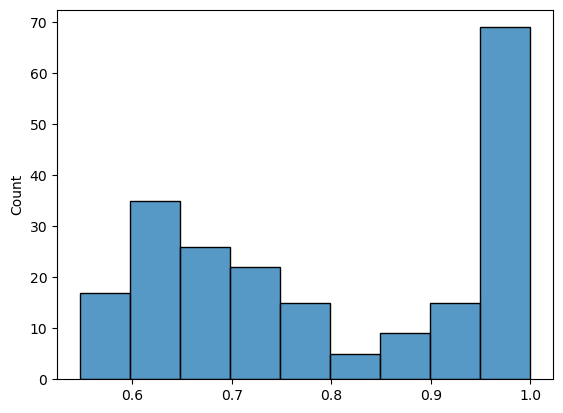

In [37]:
sns.histplot(x=fscores)

In [38]:
dfs_merge

,fscore,support,tcav_log_ratio,concept,control,layer_attr_key
0,0.998932,"[484, 453]",-1.459535,AC0134:HSF:HSF,random_regions,Nanog
1,0.998932,"[484, 453]",4.606392,AC0134:HSF:HSF,random_regions,Klf4
2,0.998932,"[484, 453]",4.615120,AC0134:HSF:HSF,random_regions,Sox2
3,0.998932,"[484, 453]",4.615120,AC0134:HSF:HSF,random_regions,Oct4
4,0.997812,"[484, 433]",4.600910,AC0077:ZIC-GLIS:C2H2_ZF,random_regions,Nanog
...,...,...,...,...,...,...
847,0.788863,"[498, 478]",3.899257,SINE_PB1D9,random_regions,Oct4
848,0.790428,"[498, 467]",0.337436,SINE_RSINE1,random_regions,Nanog
849,0.790428,"[498, 467]",3.218748,SINE_RSINE1,random_regions,Klf4
850,0.790428,"[498, 467]",4.287907,SINE_RSINE1,random_regions,Sox2


In [39]:
# filter out concepts don't meet the fscore requirements
dfs_merge = dfs_merge.loc[dfs_merge.fscore > fscore_threshold]

In [40]:
dfs_merge

,fscore,support,tcav_log_ratio,concept,control,layer_attr_key
0,0.998932,"[484, 453]",-1.459535,AC0134:HSF:HSF,random_regions,Nanog
1,0.998932,"[484, 453]",4.606392,AC0134:HSF:HSF,random_regions,Klf4
2,0.998932,"[484, 453]",4.615120,AC0134:HSF:HSF,random_regions,Sox2
3,0.998932,"[484, 453]",4.615120,AC0134:HSF:HSF,random_regions,Oct4
4,0.997812,"[484, 433]",4.600910,AC0077:ZIC-GLIS:C2H2_ZF,random_regions,Nanog
...,...,...,...,...,...,...
767,0.930051,"[498, 447]",4.473102,SINE_B2_Mm1a,random_regions,Oct4
768,0.905391,"[498, 485]",-4.023066,SINE_B2_Mm1t,random_regions,Nanog
769,0.905391,"[498, 485]",4.507082,SINE_B2_Mm1t,random_regions,Klf4
770,0.905391,"[498, 485]",2.800212,SINE_B2_Mm1t,random_regions,Sox2


### CAV correlation

Save the positively associated regions for each cluster

In [53]:
motif_clustering_pwms = motifs.parse(open(motifs_pwm_meme), fmt='MINIMAL')
motif_clustering_pwms = {m.name: m.pwm for m in motif_clustering_pwms} # index pwm by AC id
def seq_logo(cav_key, ax=None, max_len=20):
    pwm = motif_clustering_pwms.get(cav_key)

    if pwm is not None:
        pwm_df = pd.DataFrame(pwm)
        motif_len = len(pwm_df)
        
        # Logomaker expects columns as A,C,G,T, so ensure correct order
        pwm_df = pwm_df[['A', 'C', 'G', 'T']]
    
        # Compute information content at each position (2 - entropy)
        def compute_ic(pwm_row):
            entropy = -sum([p * np.log2(p) if p > 0 else 0 for p in pwm_row])
            return 2 - entropy
        
        # Compute IC matrix: IC_letter = p * IC_total
        ic_df = pwm_df.copy()
        for i in range(len(pwm_df)):
            ic_total = compute_ic(pwm_df.iloc[i])
            ic_df.iloc[i] = pwm_df.iloc[i] * ic_total
    
        
        # Plot with logomaker
        x0, y0, width, height = ax.get_position().bounds
        ax.set_position([x0, y0, width * min(1., motif_len/max_len), height])
        logo = logomaker.Logo(ic_df, color_scheme={'A': 'red', 'C': 'blue',
                                                  'G': 'orange', 'T': 'green'},
                              ax=ax)
        logo.ax.axis('off')
    else:
        print(f'PWM not found for {cav_key}')
        ax3.axis('off')


<Figure size 1300x800 with 0 Axes>

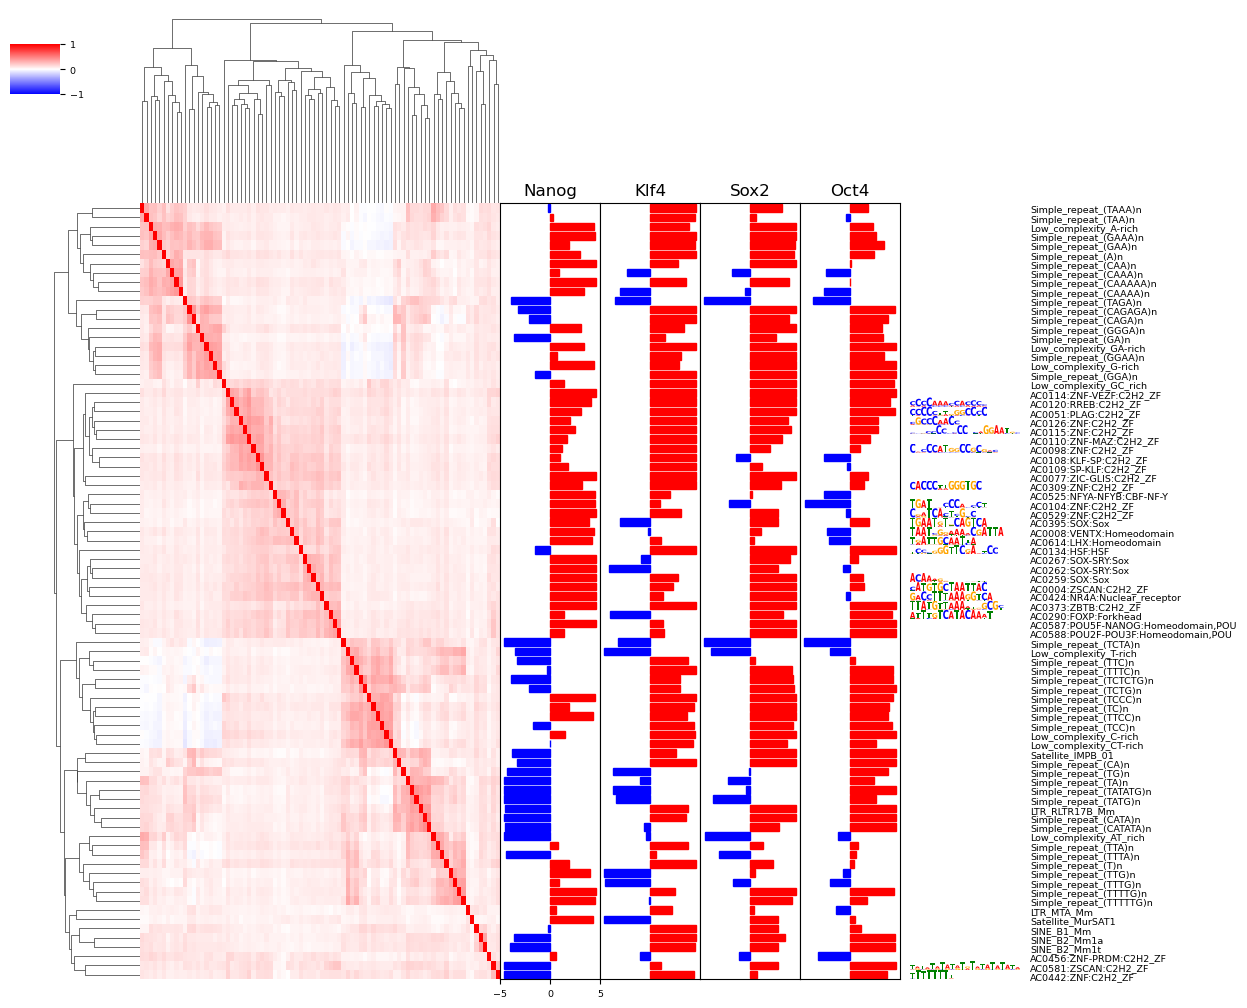

In [68]:
clustermap_width = 0.5
barplot_width = 0.4 / len(layer_attrs_prefixes) # compute barplot width for each of the layer attrs
logo_width = 0.1
text_width = 0.1

text_size = 40/np.log(len(dfs_merge))

if len(dfs_merge) > 0:
    cavs_stack = {}
    for concept, cav_list in cavs.items():
        if concept in dfs_merge.concept.tolist():
            cavs_key = concept
            cavs_stack[cavs_key] = torch.stack(cav_list).mean(dim=0)[0]
    cavs_keys = list(cavs_stack.keys())
    cavs_stack = torch.stack(list(cavs_stack.values()))
    
    from sklearn.metrics.pairwise import cosine_similarity
    if cavs_stack.shape[0] > 1:

        fig = plt.figure(figsize=(13, 8))
        sfigs = fig.subfigures(2, 1)
        
        plt.rc('xtick', labelsize=text_size)
        plt.rc('ytick', labelsize=text_size)
        
        matrix_similarity = cosine_similarity(cavs_stack.detach().numpy())
        cm = sns.clustermap(matrix_similarity, xticklabels=False, yticklabels=False, cmap='bwr',
                       vmin=-1, vmax=1)
        labels = fcluster(cm.dendrogram_row.linkage, 10, criterion='maxclust')

        # set color bar loc
        cm.gs.update(left=0.05, right=clustermap_width)
        cm.ax_cbar.set_position([.01, 0.9, .05, .05])

        cavs_keys_reordered = [cavs_keys[i] for i in cm.dendrogram_col.reordered_ind]

        # plot Log ratio barplots
        for i, layer_attr_key in enumerate(layer_attrs_prefixes.keys()):
            log_ratios = dfs_merge.loc[dfs_merge.layer_attr_key==layer_attr_key].set_index('concept').loc[cavs_keys_reordered, 'tcav_log_ratio'].tolist()
            
            ## create new gridspec for the log ratio barplot
            gs2 = gridspec.GridSpec(1, 1)
            ## create axes within this new gridspec
            ax2 = cm.fig.add_subplot(gs2[0])
    
            heatmap_bbox = cm.ax_heatmap.get_position()
            ax2.set_position([0.5+i*barplot_width, heatmap_bbox.y0, barplot_width, heatmap_bbox.height])
    
            ## plot log ratio
            ax2.tick_params(axis='y', which='major', pad=fig.get_size_inches()[0] * logo_width * 72)
            sns.barplot(y=cavs_keys_reordered, x=log_ratios, orient="y", ax=ax2)
            ## set color of bar by value
            for idx in range(len((ax2.containers[0]))):
                if ax2.containers[0].datavalues[idx] > 0:
                    ax2.containers[0][idx].set_color('red')
                else:
                    ax2.containers[0][idx].set_color('blue')
            
            ax2.set_xlim(left=-5, right=5)
            ax2.yaxis.tick_right()
            if i != 0:
                ax2.axes.get_xaxis().set_visible(False)
            ax2.axes.get_yaxis().set_visible(False)
            ax2.set_title(layer_attr_key)

        # plot PWM logos
        gs3 = gridspec.GridSpec(len(cavs_keys_reordered), 1)

        logo_height = heatmap_bbox.height/len(cavs_keys_reordered)
        for i, (cav_key, g) in enumerate(zip(cavs_keys_reordered[::-1], gs3)):
            ax3 = plt.subplot(g)
            ax3.set_position([0.5+len(layer_attrs_prefixes)*barplot_width+0.01, heatmap_bbox.y0+i*logo_height, logo_width+0.01, logo_height])
            if cav_key is not None:
                seq_logo(cav_key, ax=ax3)
            else:
                ax3.axis('off')

        # plot cav keys
        gs4 = gridspec.GridSpec(len(cavs_keys_reordered), 1)
        text_height = heatmap_bbox.height/len(cavs_keys_reordered)
        for i, (cav_key, g) in enumerate(zip(cavs_keys_reordered[::-1], gs4)):
            ax4 = plt.subplot(g)
            ax4.set_position([0.5+len(layer_attrs_prefixes)*barplot_width+logo_width+0.03, heatmap_bbox.y0+i*text_height, text_width+0.01, text_height])
            ax4.text(0, 0, cav_key, transform=ax4.transAxes, fontsize=text_size)
            ax4.axis('off')
        
        plt.savefig(f"{output_dir}/tcav_cav_correlation_full.pdf", bbox_inches="tight")
